# <font color=red>HW01-q1 Vision Course, Harris Corner Detection and Matching</font>
This is the notebook for **q1.py** that is the implementation of **Harris Corner Detection and Matching**. <br>
The code is written by **Asal Mehradfar** with student number **96105434**.

## <font color=orange>Description</font>

The complete way of this algorithm was explained in the **sheet**, just for more detailed description I mention some points here.


*   I used **Sobel Algorithm** for edge detection, because it worked better than other ways.
*   There were a lot of ways of implementation for the **NMS Algorithm**. I have chosen the way of comparing the magnitudes in a circle around a special pixel. I started from the left side of the image so in every step I just compared the magnitudes with the pixels in the right side of the circle. 
*   The **NMS Algorithm** is a bit slower than other parts, so depending on the system you are using you should wait some minutes for running. In *Google Colab* it takes 5 minutes for both images.
*   All the functions have a complete description in both .py and notebook files.
*   About the final results, we can increase the number of matched points by increasing the threshold, but it may cause some unwanted match points.
*   All the results were scaled to 0-255 as the document suggested, different results may be achieved if we do not scale them.
*   In the algorithm that was implemented, I convert the original images to gray ones at first and then work with the gray ones till the end. At the last step that we need to show the matched points on the images I just plot the colorful ones.



### <font color=yellow>Upgrading Open-CV in Google Colab</font>

In [1]:
!pip3 install --upgrade opencv-python

     |████████████████████████████████| 49.9 MB 16 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


### <font color=yellow>Imports</font>

In [2]:
import numpy as np
import cv2
from scipy import signal
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter
from matplotlib.patches import ConnectionPatch
import math

### <font color=yellow>Parameters</font>

*   SIGMA = 2
*   K = 0.1
*   N = 51
*   THRESHOLD1 = 1e6
*   THRESHOLD2 = 1.25

In [3]:
SIGMA = 2
K = 0.1
N = 51
THRESHOLD1 = 1e6
THRESHOLD2 = 1.25
NMS_RADIUS = 10 # not in the wanted parameters list

### <font color=yellow>Functions</font>

In [4]:
def get_img(path):
    """
    Read the image file from the path and change it from BGR to RGB
    pay attention that in open-cv colorful images are BGR **NOT** RGB
    
    Inputs:
    --> path: path for the image
    Outputs:
    ==> img: the RGB image
    """
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

def plot_gray_img(img, path= None):
    """
    Plot a gray img and save it if needed
    
    Inputs:
    --> img: the desired image
    --> path: the default value is None, if it is given the image will be saved in the path
    Outputs:
    ==> Nothing, the image will be plotted
    """
    fig = plt.figure(figsize=(16, 8))
    plt.imshow(img, cmap= 'gray')
    plt.axis('off')
    if path is not None :
        fig.savefig(path, bbox_inches='tight')
    plt.show()

def get_gray_img(path):
    """
    Read the image file from the path and change it to the gray one
    
    Inputs:
    --> path: path for the image
    Outputs:
    ==> gray_img: the gray image
    """
    img = cv2.imread(path)
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return gray_img

def get_sobel_kernels():
    """
    makes the kernels for the Sobel Algorithm of finding edges
    
    Inputs:
    --> Nothing
    Outputs:
    ==> Gx: the 3*3 kernel of Sobel Algorithm for edges in x direction
    ==> Gy: the 3*3 kernel of Sobel Algorithm for edges in y direction
    pay attention that x and y in open-cv are different from x and y in real life!!!
    """
    Gx = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    Gy = Gx.transpose()
    return Gx, Gy

def compute_2d_convolution(a, b):
    """
    returns the 2d convolution result of the outputs
    
    Inputs:
    --> a: first array to be convolved
    --> b: second array to be convolved
    Outputs:
    ==> the 2d convolution result
    pay attention that if we put **same** instead of **valid** we will have zero padding
    in Harris Corner Detection it causes corners of the complete image to be detected as edges, which is not true. 
    """
    return signal.convolve2d(a, b, mode='valid')

def sobel_filtering(img):
    """
    return the grads of the input image in x and y direction
    
    Inputs:
    --> img: the desired image for computing grads
    Outputs:
    ==> Ix: the grad in x direction computed by Sobel Algorithm
    ==> Iy: the grad in y direction computed by Sobel Algorithm
    pay attention that x and y in open-cv are different from x and y in real life!!! 
    """
    Gx, Gy = get_sobel_kernels()
    Ix  = compute_2d_convolution(img, Gx)
    Iy  = compute_2d_convolution(img, Gy)
    return Ix, Iy

def compute_grads_products(Ix, Iy):
    """
    return the products of grads
    
    Inputs:
    --> Ix: the grad in x direction computed by Sobel Algorithm
    --> Iy: the grad in y direction computed by Sobel Algorithm
    Outputs:
    ==> Ix2: Ix ^ 2
    ==> Iy2: Iy ^ 2
    ==> Ixy: Ix * Iy
    """
    Ix2 = np.multiply(Ix, Ix)
    Iy2 = np.multiply(Iy, Iy)
    IxIy = np.multiply(Ix, Iy)
    return Ix2, Iy2, IxIy

def scaling_img(img):
    """
    return the scaled image usually for saving 
    
    Inputs:
    --> img: the desired image for scaling
    Outputs:
    ==> scaled_img: we assume that the minimum of the image is zero
        so we scale it by devision by its maximum and multiplying it by 255.0
    """
    scaled_img = 255.0 * img / np.max(img)
    return scaled_img

def normalize_img(img):
    """
    return the normalized image 
    
    Inputs:
    --> img: the desired image for scaling
    Outputs:
    ==> norm_img: we assume that the minimum of the image is zero
        so we normalize it by devision by its maximum
    """
    norm_img = img / np.max(img)
    return norm_img

def get_grad_magnitude(Ix2, Iy2):
    """
    return the sqrt of the of sum of two grads
    
    Inputs:
    --> Ix2: Ix ^ 2
    --> Iy2: Iy ^ 2
    Outputs:
    ==> the matrix of magnitudes of the image grads in each point 
    """
    return np.sqrt(Ix2 + Iy2)

def save_img(array, path, scaled=False):
    """
    save the input image in the desired path

    Inputs:
    --> array: the array of an image
    --> path: the desired path for saving the image
    --> scaled: the default value is False,
    if it is given True the image will be scaled into [0,255]
    Outputs:
    ==> Nothing, just saving the image
    """
    if scaled:
        array = scaling_img(array).astype(np.uint8)
    img = Image.fromarray(array)
    img.save(path)

def grads_products_gaussian_filter(sigma, Ix2, Iy2, IxIy):
    """
    return blurred grads products by gaussian filter
    
    Inputs:
    --> sigma: the standard deviation for the gaussian filter (around 1 or 2)
    --> Ix2: Ix ^ 2
    --> Iy2: Iy ^ 2
    --> Ixy: Ix * Iy
    Outputs:
    ==> Sx2: blurred Ix2
    ==> Sy2: blurred Iy2
    ==> Sxy: blurred Ixy
    """
    Sx2 = gaussian_filter(Ix2, sigma= sigma)
    Sy2 = gaussian_filter(Iy2, sigma= sigma)
    Sxy = gaussian_filter(IxIy, sigma= sigma)
    return Sx2, Sy2, Sxy

def get_structure_tensor(Sx2, Sy2, Sxy):
    """
    make the stucture tensor of the image by blur grads
    
    Inputs:
    --> Sx2: blurred Ix2
    --> Sy2: blurred Iy2
    --> Sxy: blurred Ixy
    Outputs:
    ==> tensor: the 2*2 stucture tensor of our image
    """
    tensor = np.array([[Sx2, Sxy], [Sxy, Sy2]])
    return tensor

def get_det_trace(tensor):
    """
    compute det and trace for the input tensor
    
    Inputs:
    --> tensor: a 2*2 tensor
    Outputs:
    ==> det: the det of the tensor
    ==> trace: the trace of the tensor
    """
    det = np.multiply(tensor[0, 0], tensor[1, 1]) - np.multiply(tensor[0, 1], tensor[1, 0])
    trace = tensor[0, 0] + tensor[1, 1]
    return det, trace

def get_harris_func(k, det, trace):
    """
    compute the Harris function 
    
    Inputs:
    --> k: a flexible parameter for the function (around 0.1 or 0.2)
    --> det: det of the structure tensor
    --> trace: trace of the structure tensor
    Outputs:
    ==> R: the output of Harris function
    """
    R = det - k * np.multiply(trace, trace)
    return R

def apply_threshold(thresh, img):
    """
    making the points more than a special thresh zero (black) in an image
    
    Inputs:
    --> thresh: a big number (!!!) which is the threshold
    --> img: the desired image for applying thresh
    Outputs:
    ==> out: the image after threshold
    """
    # out = img * (img > thresh)
    out = (img > thresh)    # for a better plot, binary
    return out

def point_nms(x, y, img, r):
    """
    this function is the implementation for the NMS Algorithm on a special point,
    which means that if in the specified radius a point exits that its value is more than the center,
    we will change the center to zero, if not we will change the value of all the points in the radius 
    to zero. pay attention that by the points in the radius we mean points in the right side of the circle.
    
    Inputs:
    --> x: x value of the center point
    --> y: y value of the center point
    --> img: the whole image
    --> r: radius of important points
    Outputs:
    ==> out: the changed image
    """
    if img[x, y] == 0:
      return img
    
    out = img.copy()
    for dx in range(-r, r):
        if x + dx < 0:
            continue
        elif x + dx >= img.shape[0]:
            break
        for dy in range(r):
            if y + dy >=  img.shape[1]:
                break
            elif dx**2 + dy**2 > r**2 or (dx == 0 and dy == 0):
                continue
            elif img[x, y] <= img[x + dx, y + dy]:
                img[x, y] = 0
                return img
            else:
                out[x + dx, y + dy] = 0
    return out

def non_maximum_suppression(img, r):
    """
    here we go through all the point in the input image and call the point_nms function
    
    Inputs:
    --> img: the whole image for NMS Algorithm after Harris function
    --> r: radius of important points around a special center
    Outputs:
    ==> out: the final image after NMS
    """
    out = img.copy()
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            out = point_nms(x, y, out, r)
    return out

def get_features(img, nms_R, n):
    """
    produce a list of interest points and a list of their feature vector
    
    Inputs:
    --> img: the whole gray image
    --> nms_R: the final image after NMS
    --> n: show the sqrt of features which means we have n ^ 2 features. 
        n should be **Odd**, between 40 to 60
    Outputs:
    ==> points_list: coordinates list of nonzero points after nms
    ==> features_list: list of n^2 features of nonzero points after nms
    pay attention that for each point we have x, y and a feature vector
    """
    features_list = []
    points_list = []

    m = int((n - 1) / 2)
    X = np.nonzero(nms_R)[0]
    Y = np.nonzero(nms_R)[1]

    for x, y in zip(X, Y):
        a = img[x-m:x+m+1, y-m:y+m+1].reshape([1, n**2])
        points_list.append([x, y])
        features_list.append(a)

    return points_list, features_list

def compute_distance(q, p):
    """
    compute the distance between vetors p and q, here feature vectors
    
    Inputs:
    --> q: first feature vector
    --> p: second feature vector
    Outputs:
    ==> the distance between q and p
    """
    delta = q - p
    return np.sqrt(np.sum(np.multiply(delta, delta)))

def compare_features(points1, features1, points2, features2, thresh):
    """
    compare the features of two groups of interest points and find match points of two images
    
    Inputs:
    --> points1: coordinates list of interest points in first image
    --> features1: features list of interest points in first image
    --> points2: coordinates list of interest points in second image
    --> features: features list of interest points in second image
    --> thresh: the threshold for accepting the match, comparing with d_2/d_1 ratio
    Outputs:
    ==> matched_points1: matched points in first image
    ==> matched_points2: matched points in second image
    """
    cons = math.inf
    matched_points1 = []
    matched_points2 = []
  
    for i in range(len(points1)):
        d1 = cons
        d2 = cons
        [x1, y1] = points1[i]
        q = features1[i]
        for j in range(len(points2)):
            [x2, y2] = points2[j]
            p = features2[j]
            d = compute_distance(q, p)
            if d < d1 and d < d2:
                d2 = d1
                d1 = d
                m = [x2, y2]
            elif d1 < d < d2:
                d2 = d
        if d2 / d1 > thresh:
            matched_points1.append([x1, y1])
            matched_points2.append(m)
          
    return matched_points1, matched_points2   

def preprocess_Harris(path, num_img=0):
    """
    preprocess images and find interest points and their features
    
    Inputs:
    --> path: path for the image
    --> num_img: this parameter is for saving the results, 
        when zero no saving, when 1 saving the results for im01.jpg, when 2 saving the results for im02.jpg
    Outputs:
    ==> points: coordinates list of interest points
    ==> features: list of features of interest points
    """
    img = get_gray_img(path)

    Ix, Iy = sobel_filtering(img)
    Ix2, Iy2, IxIy = compute_grads_products(Ix, Iy)
    grad = get_grad_magnitude(Ix2, Iy2)
    Sx2, Sy2, Sxy = grads_products_gaussian_filter(SIGMA, Ix2, Iy2, IxIy)
    tensor = get_structure_tensor(Sx2, Sy2, Sxy)
    det, trace = get_det_trace(tensor)
    R = get_harris_func(K, det, trace)
    R_thresh = apply_threshold(THRESHOLD1, R)
    nms_R = non_maximum_suppression(R_thresh, NMS_RADIUS)
    points, features = get_features(normalize_img(img), nms_R, N)

    if num_img == 1:
        save_img(grad, 'res01_grad.jpg', True)
        save_img(R, 'res03_score.jpg', True)
        save_img(R_thresh, 'res05_thresh.jpg', True)
        save_img(nms_R, 'res07_harris.jpg', True)
    elif num_img == 2:
        save_img(grad, 'res02_grad.jpg', True)
        save_img(R, 'res04_score.jpg', True)
        save_img(R_thresh, 'res06_thresh.jpg', True)
        save_img(nms_R, 'res08_harris.jpg', True)

    return points, features  

def get_final_matched_points(matched_points1, matched_points2, matched_points3, matched_points4):
    """
    get final match points
    
    Inputs:
    --> matched_points1: matched points of image 1 by matching image 2 to image 1
    --> matched_points2: matched points of image 2 by matching image 2 to image 1
    --> matched_points1: matched points of image 2 by matching image 1 to image 2
    --> matched_points2: matched points of image 1 by matching image 1 to image 2
    Outputs:
    ==> out1: final matched points of image1
    ==> out2: final matched points of image2
    """
    out1 = []
    out2 = []
    for i in range(len(matched_points1)):
        for j in range(len(matched_points3)):
            if matched_points2[i] == matched_points3[j] and matched_points4[j] == matched_points1[i]:
                out1.append(matched_points1[i])
                out2.append(matched_points2[i])
                break
    return out1, out2

def draw_matched_points(path, img_matched, num_img=0):
    """
    draw matched points on an image
    
    Inputs:
    --> path: path for the original image
    --> img_matched: coordinates list of matched points in the image
    --> num_img: this parameter is for saving the results, 
        when zero no saving, when 1 saving the results for im01.jpg, when 2 saving the results for im02.jpg
    Outputs:
    ==> Nothing
    """
    fig = plt.figure(figsize=(8, 8))
    cmap = plt.get_cmap('gist_rainbow')
    plt.imshow(get_img(path))
    plt.axis('off')
    i = 0

    for a in img_matched:
        c = cmap(i / len(img_matched))
        [x1, y1] = [a[0], a[1]]
        plt.plot(y1,x1,'ro',markersize=6, color= c)
        i += 1   
    if num_img == 1:
       fig.savefig('res09_corres.jpg', bbox_inches='tight')
    elif num_img == 2:
        fig.savefig('res10_corres.jpg', bbox_inches='tight')
    # plt.show()

def draw_matched_lines(path1, img1_matched, path2, img2_matched, save=False):
    """
    draw lines between matched points on two images
    
    Inputs:
    --> path1: path for the first original image
    --> img1_matched: coordinates list of matched points in the first image
    --> path2: path for the second original image
    --> img1_matched: coordinates list of matched points in the second image
    --> save: boolean for saving the results, saving when True
    Outputs:
    ==> Nothing
    """
    fig = plt.figure(figsize=(15, 15))
    cmap = plt.get_cmap('gist_rainbow')
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.imshow(get_img(path1))
    ax1.axis('off')
    ax2.imshow(get_img(path2))
    ax2.axis('off')
    i = 0

    for a, b in zip(img1_matched, img2_matched):
        c = cmap(i / len(img1_matched))
        [x1, y1, x2, y2] = [a[0], a[1], b[0], b[1]]
        con = ConnectionPatch(xyA=[y1, x1], xyB=[y2, x2], coordsA="data", coordsB="data", axesA=ax1, axesB=ax2, color = c)
        ax2.add_artist(con)
        ax1.plot(y1,x1,'ro',markersize=5, color= c)
        ax2.plot(y2,x2,'ro',markersize=5, color= c)
        i += 1   
    if save:
       fig.savefig('res11.jpg', bbox_inches='tight')
    # plt.show()

### <font color=yellow>Main Part, Test on im01.jpg and im02.jpg</font>

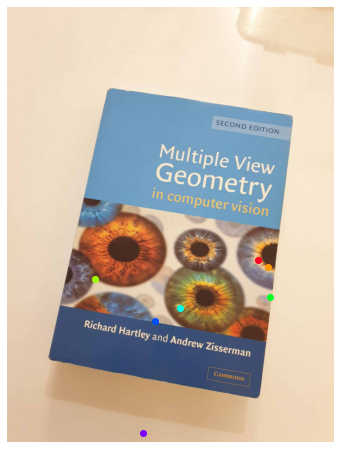

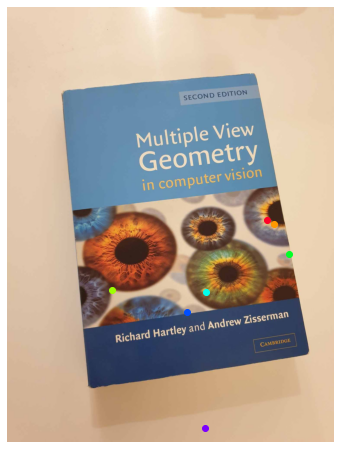

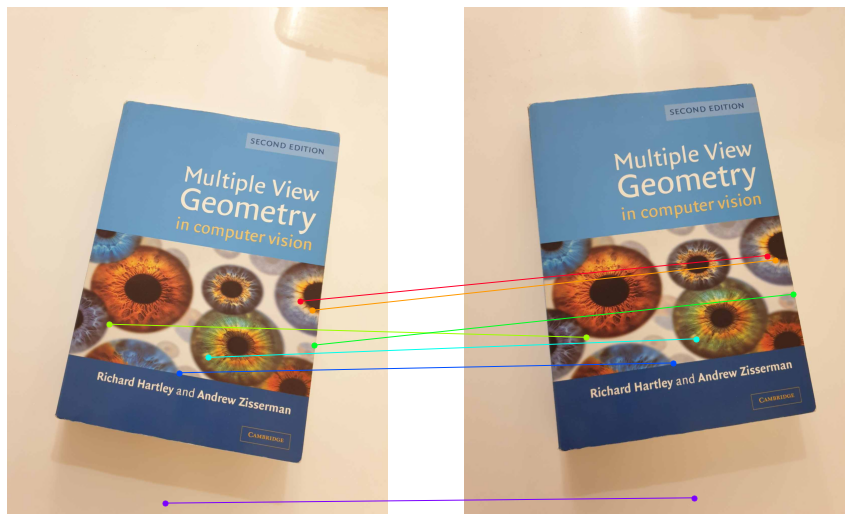

In [5]:
points1, features1 = preprocess_Harris('im01.jpg', 1)
points2, features2 = preprocess_Harris('im02.jpg', 2)
matched_points1 , matched_points2 = compare_features(points1, features1, points2, features2, THRESHOLD2)
matched_points3 , matched_points4 = compare_features(points2, features2, points1, features1, THRESHOLD2)
img1_matched, img2_matched = get_final_matched_points(matched_points1, matched_points2, matched_points3, matched_points4)
draw_matched_points('im01.jpg', img1_matched, 1)
draw_matched_points('im02.jpg', img2_matched, 2)
draw_matched_lines('im01.jpg', img1_matched, 'im02.jpg', img2_matched, True)